In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression, PoissonRegressor
from sklearn.tree import DecisionTreeRegressor

import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from analysis import get_feature_importances, visualize_decision_trees, get_vif, wl_accuracy, season_record, runs_per_game

In [2]:
version = 6
df = pd.read_csv(f'./data/baseball/training/game_data_v{version}.csv')

In [3]:
# create the appropriate training and testing data based on home/away, dropping columns as needed
def create_data(drop_cols=['away_score', 'home_score', 'away_team', 'home_team'], y_col='away_score', split_by='random'):
    y = df[y_col]
    x = df.drop(drop_cols, axis=1)

    if split_by == 'season':
        x_train, x_test = x.iloc[0:13047], x.iloc[13047:]
        y_train, y_test = y.iloc[0:13047], y.iloc[13047:]
        # x_train, x_test = x.iloc[0:10617], x.iloc[10617:]
        # y_train, y_test = y.iloc[0:10617], y.iloc[10617:]
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True)
    
    return x_train, x_test, y_train, y_test

In [4]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(y_col='away_score', split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(y_col='home_score', split_by='season')

In [5]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt')

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print('RANDOM FOREST REGRESSION MODEL (v2 - with increased variance)')
print(f'Accuracy: {wl_accuracy(results)}%')
print('-' * 30)
season_record(df, results)
print('-' * 30)
runs_per_game(df, results)

RANDOM FOREST REGRESSION MODEL (v2 - with increased variance)
Accuracy: 53.49794238683128%
------------------------------
Season records:
ATL: 116-46	LAD: 107-55	MIN: 100-62	TOR: 99-63	MIL: 96-66	
TB: 96-66	BAL: 93-69	HOU: 93-69	TEX: 92-70	PHI: 90-72	
SD: 87-75	NYM: 86-76	CHC: 84-78	CIN: 83-79	STL: 83-79	
NYY: 83-79	CLE: 82-80	SEA: 80-82	DET: 79-83	BOS: 78-84	
LAA: 75-87	SF: 73-89	AZ: 71-91	MIA: 71-91	KC: 65-97	
WSH: 58-104	CWS: 58-104	PIT: 55-107	OAK: 50-112	COL: 47-115	
------------------------------
Runs scored per game:
ATL: 5.62 (910)	LAD: 5.09 (825)	TEX: 4.92 (796)	TB: 4.91 (796)	STL: 4.89 (793)	
HOU: 4.85 (785)	SD: 4.8 (777)	CLE: 4.78 (774)	PHI: 4.75 (770)	BAL: 4.65 (754)	
TOR: 4.64 (752)	CHC: 4.63 (750)	DET: 4.62 (749)	LAA: 4.62 (748)	MIN: 4.6 (746)	
MIL: 4.57 (740)	SEA: 4.57 (740)	MIA: 4.54 (735)	KC: 4.53 (734)	CIN: 4.53 (734)	
NYY: 4.46 (722)	NYM: 4.4 (712)	AZ: 4.32 (700)	SF: 4.18 (678)	BOS: 4.16 (674)	
OAK: 4.16 (673)	PIT: 4.14 (670)	WSH: 4.06 (658)	COL: 4.06 (658)	CWS: 3.95

By using fewer decision trees, the aggregate records came out to be more realistic - even if it did come at the cost of losing some accuracy. Looking at the histogram below, we can see that this modified version has a mean accuracy of about 53%, which is still better than a random guessing model.

                0
count  100.000000
mean    52.990535
std      1.085924
min     50.493827
25%     52.294239
50%     52.901235
75%     53.590535
max     55.637860


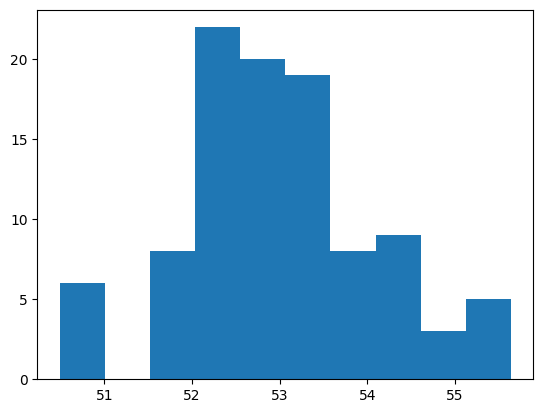

In [6]:
acc = []

for i in range(100):
    model_away.fit(x_train_away, y_train_away)
    model_home.fit(x_train_home, y_train_home)
    
    pred_away = model_away.predict(x_test_away)
    pred_home = model_home.predict(x_test_home)
    
    results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
    results.describe()
    
    acc.append(wl_accuracy(results))


print(pd.DataFrame(acc).describe())

plt.hist(acc)
plt.show()

In [ ]:
# visualize_decision_trees(model_home, x_test_home.columns)